In [1]:
%pylab inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Populating the interactive namespace from numpy and matplotlib


### LDA基本原理
- 使同类样本的投影点尽可能接近，即投影点的协方差尽可能小，即$\omega^T\Sigma_0\omega + \omega^T \Sigma_1\omega$
- 使异类样本尽可能远离，即各个类别中心距离尽可能远，$\parallel\omega^T\mu_0 - \omega^T\mu_1\parallel$
- 主要求取两个协方差矩阵 
    1. 类内散度矩阵: 
    
    $\begin{align}S_{\omega} &= \Sigma_0 + \Sigma_1 \\ &= \sum(x - \mu_0)(x-\mu_0)^T  + \sum(x-\mu_1)(x-\mu_1)^T \end{align}$
    
    2. 类间散度矩阵:
    
    $S_b = (\mu_0-\mu_{total})(\mu_1-\mu_{total})^T$
    
    
- 本身具有降维的作用

(3, 2)
(3,)


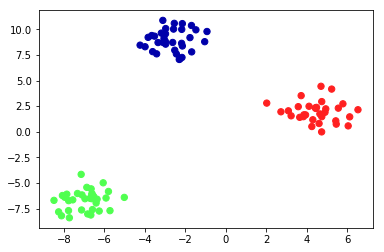

In [3]:
# 构造数据集
# 用支持向量分类器分类
from sklearn.datasets import make_blobs
from sklearn.svm import LinearSVC
import mglearn

X, y = make_blobs(random_state=42)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=mglearn.cm3)
linear_svm = LinearSVC().fit(X, y)
print(linear_svm.coef_.shape)
print(linear_svm.intercept_.shape)

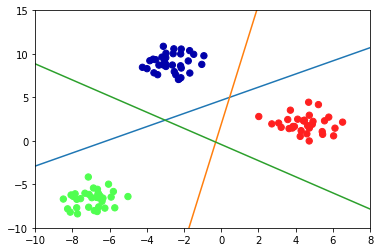

In [4]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=mglearn.cm3)
line = np.linspace(-15, 15)
for coef, intercept in zip(linear_svm.coef_, linear_svm.intercept_):
    plt.plot(line, -(line * coef[0] + intercept) / coef[1])
    plt.ylim(-10, 15)
    plt.xlim(-10, 8)

discriminant plain:
[[-0.5849896  -0.86574354]
 [-0.8110408   0.50048789]]



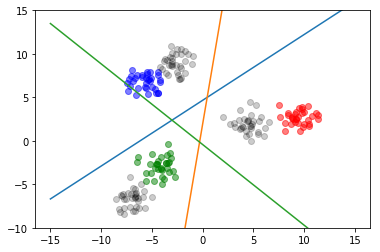

In [5]:
# labels is y, data is X, 4 clusters, dimentions(properties)

# overall centroid of inputs points
def total_mean(data):
    return data.mean(0)

# centroids matrix K * p, class: K, dim: p
def class_mean(data, labels, clusters):
    M = []
    for i in range(clusters): 
        # centroid for each class
        mu = np.mean(data[labels == i,:],0)
        M.append(mu)
   
    return M

# with-in class cov matrix
def with_in_class(data,labels,clusters):
    # dimensions of data
    dim = data.shape[1]
    # with-in matrix
    W = np.zeros((dim,dim))
    mean_vectors = class_mean(data, labels, clusters)
    for lab, mv in zip(range(clusters), mean_vectors):
        # with-in cov matrix of current class 
        cur_w = np.zeros((dim,dim))
        for row in data[labels == lab,:]:  
            cur_w += np.dot((row - mv).reshape(dim,1), 
                            (row - mv).reshape(1,dim))
        W += cur_w
    return W

# between class cov matrix
def between_class(data, labels, clusters):
    dim = data.shape[1]
    B = np.zeros((dim,dim))
    mu_t = total_mean(data)
    mean_vectors = class_mean(data, labels, clusters)
    for lab, mv in zip(range(clusters), mean_vectors):
        n = len(data[labels == lab,:])
        B += np.dot((mv - mu_t).reshape(dim,1), (mv - mu_t).reshape(1,dim))
    return B


def LDA(data, labels, clusters):
    dim = data.shape[1]
    W = with_in_class(data, labels, clusters)
    B = between_class(data, labels, clusters)
    e_vals, e_vecs = np.linalg.eig(np.linalg.inv(W).dot(B))
        
    pairs = [(np.abs(e_vals[i]), e_vecs[:,i]) for i in range(len(e_vals))]
    # the two largest egien values
    pairs = sorted(pairs, key=lambda k: k[0], reverse=True)
    # only use first two canonical variates
    v = np.hstack((pairs[0][1].reshape(dim,1), pairs[1][1].reshape(dim,1)))
    
    print('discriminant plain:\n{}\n'.format(v))
    
    return v

def LDA_classify(data,labels, clusters):
    w = LDA(data,labels,clusters)
    res = data.dot(w)
    res = res.reshape((res.shape[0],2))
    return res

res = LDA_classify(X,y,3)

def scatter_plot_res(data, labels):
    for lab,color in zip(np.unique(labels),('blue','green','red')):
        plt.scatter(data[labels == lab,0],
                    data[labels==lab,1],
                    color = color,
                   alpha = .5) 
        
scatter_plot_res(res,y)
plt.plot(X[:,0],X[:,1],'ko',alpha=.2)
for coef, intercept in zip(linear_svm.coef_, linear_svm.intercept_):
    plt.plot(line, -(line * coef[0] + intercept) / coef[1])
    plt.ylim(-10, 15)